# Plot spots on top of segmentation mask to highlight spot assignment and cell type classification

In [1]:
# just installing napari, geopandas and tifffile should be enough to import everything
import pandas as pd
import napari
import tifffile
import geopandas as gp
from shapely.geometry import Polygon
import distinctipy
import seaborn as sns
import colorcet as cc
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from skimage.segmentation import find_boundaries
from spatialMI_functions import plot_layers_napari, crop_black_margins, plot_pixie_maps, crop, crop_mask, crop_black_margins, crop_coords

colorblind = sns.color_palette("colorblind")
glasbey = sns.color_palette(cc.glasbey)

In [96]:
#genes_of_interest = ["Nppb","Pln","Pecam1","Nppa"]
sample = "sample_4h_r1_s1"
colors = ["#fc6b09","#0090ad","#cadb2b","#cb2027","#029e88", "#e18d9a"]

## Where to save the napari screenshot
napari_screenshot = '../../output/mol_cart/spots_on_mask.sample_4h_r1_s1.napari_screen.roi_image.png'

## Region of interest
roi = pd.read_csv("../../data/molkart_tissue_regions_rois/sample_4h_r1_s1.spots_on_mask.csv")

#### Format points
points_data =   pd.read_csv('../../../data/nf_molkart_results/dedup_spots/sample_4h_r1_s1.spots_markedDups.txt', 
                           delimiter='\t', header=None,names=['x', 'y', 'z', 'gene'])
# points_data['gene'] = pd.Categorical(
#     points_data['gene'], genes_of_interest)
# points_data = points_data[points_data.gene.isin(
#     genes_of_interest)]
gdf = gp.GeoDataFrame(
    points_data, geometry=gp.points_from_xy(
        points_data.x, points_data.y)
        )
polygon = Polygon(roi.iloc[:, :-3:-1].to_numpy())
poly_gpd = gp.GeoDataFrame(index=[0], geometry=[polygon])

# Basically fastest way to get all points within a polygon.
subset_points = gp.sjoin(gdf, poly_gpd, predicate='within')
points_view = crop_coords(roi, subset_points)
xmax, ymax = points_view["x"].max(), points_view["y"].max()
points_view = points_view.sort_values(by='gene')
points_view['cell_id'] = points_view.index
points_props = {'cell_id': points_view['cell_id'].to_numpy(),
                'gene': points_view['gene'].to_numpy()}

## Mask formatting
mask = "/Users/florian_wuennemann/1_Projects/MI_project/data/nf_molkart_results/retained_masks/sample_4h_r1_s1_cellpose.retained_masks.tif"
cell_mask = tifffile.TiffFile(mask).asarray()
mask_view = crop_mask(roi,cell_mask)
boundaries = find_boundaries(mask_view, mode='thin')

In [97]:
unique_values = np.unique(mask_view)
cell_ids = ["sample_4h_r1_s1-cell_" + str(value) for value in unique_values]
cell_types = pd.read_csv("../../output/mol_cart/molcart.misty_celltype_table.tsv", sep="\t")
subset_cell_types = cell_types[cell_types['sample_ID'] == 'sample_4h_r1_s1']
subset_cell_types = subset_cell_types[subset_cell_types['cell_ID'].isin(cell_ids)]
subset_cell_types = subset_cell_types[['cell_ID', 'anno_cell_type_lv2']]
subset_cell_types['mask_id'] = subset_cell_types['cell_ID'].str.split('_').str[-1]
subset_cell_types['cell_type_id'] = subset_cell_types.groupby('anno_cell_type_lv2').ngroup() + 1
for _, row in subset_cell_types.iterrows():
    mask_id = int(row['mask_id'])
    cell_type_id = int(row['cell_type_id'])
    mask_view = np.where(mask_view == mask_id, cell_type_id, mask_view)


In [98]:
# Show me all unique values in cell_type_id in table subset_cell_types
unique_cell_type_ids = subset_cell_types['cell_type_id'].unique()
unique_cell_type_ids
color_dict = {cell_type_id: color for cell_type_id, color in zip(unique_cell_type_ids, colorblind[1:])}
# Print the table of unique combinations between mask_id and cell_type_id in subset_cell_types
unique_combinations = subset_cell_types[['anno_cell_type_lv2', 'cell_type_id']].drop_duplicates()
unique_combinations

,anno_cell_type_lv2,cell_type_id
46561,Cardiomyocytes,2
46566,Cardiomyocytes_Nppb+,4
46576,Vascular_endothelium,10
46621,Cardiac_fibroblasts,1
46666,Lymphoid cells,7
46689,Pericytes,9
46895,Cardiomyocytes_Nppa+,3
46916,EndMA+,5
47080,Myeloid_cells,8
47249,Endocardial_cell,6


In [103]:
viewer = napari.Viewer()
img_name = "../../output/mol_cart/spots_on_mask.png"
#crop_name = "../../output/seqIF/figure3_zoomins/"+sample+".figure3_cell_mask.crop.4h.png"
viewer.add_points(points_view[['y', 'x']].to_numpy(),
                          #properties=points_props,
                          #face_color='gene',
                          #face_color_cycle=colors,
                          face_color_cycle = ["lightgrey"],
                          size=6,
                          edge_width_is_relative=False)
viewer.add_labels(boundaries, visible=True, name=sample + "_mask", opacity = 1,color={0:'transparent', 1:(1,1,1)})
viewer.add_labels(mask_view, color = color_dict)
viewer.screenshot(path=img_name,
                      scale=5)

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

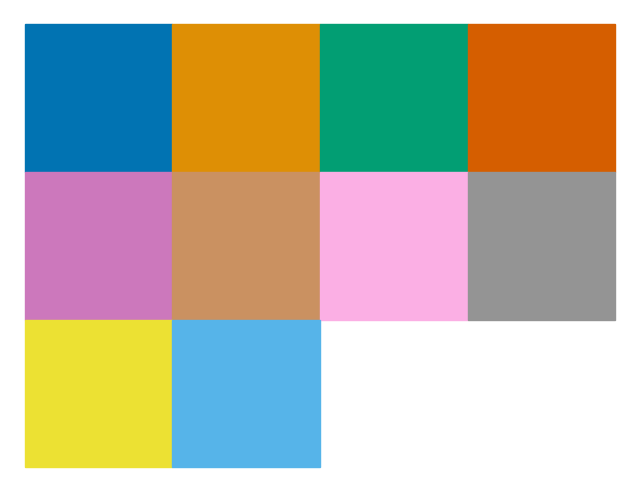

In [76]:
distinctipy.color_swatch(colorblind)